In [8]:
from Bio.PDB import *
import os
import numpy as np
from common.res_infor import label_res_dict
from utils.data import *
from utils.plot import *
from utils.dataset import *
import math
from diffusion_model.coordinate_diffusion_model import *

In [9]:
train_pdbs, train_pdb_chains = read_domain_ids_per_chain_from_txt('./data/train_domains.txt')
test_pdbs, test_pdb_chains = read_domain_ids_per_chain_from_txt('./data/test_domains.txt')

In [10]:
# save data in npy format
# train_data_coords, train_data_res = load_backbone_coords(train_pdb_chains)
# test_data_coords, test_data_res = load_backbone_coords(test_pdb_chains)
# np.save('./data/train_backbone_coords_20.npy', train_data_coords)
# np.save('./data/train_data_res_20.npy', train_data_res)
# np.save('./data/test_backbone_coords_20.npy', test_data_coords)
# np.save('./data/test_data_res_20.npy', test_data_res)

In [11]:
train_loader = BackboneCoordsDataLoader(train_pdb_chains, "./data/train_backbone_coords_20.npy", "./data/train_data_res_20.npy",seq_length=20, batch_size=128, shuffle=True)
test_loader = BackboneCoordsDataLoader(test_pdb_chains, './data/test_backbone_coords_20.npy', './data/test_data_res_20.npy', seq_length=20, batch_size=128, shuffle=True)

In [20]:


# Prepare data
pdb_chain = next(iter(train_loader))[0]
res_label = next(iter(train_loader))[1]
atom_coords = next(iter(train_loader))[2]

data = []
for i in range(len(pdb_chain)):
    sequence = ""
    for label in res_label[i]:
        aa = label_res_dict[label.item()]
        sequence += aa
    data.append((pdb_chain[i], sequence))
print(data)

[('1fhjA', 'GMELPSFIFQAQENLVERPW'), ('3nngA', 'MVEIFNEIMQRVKEAETIII'), ('3au4A', 'FNKILIANRGEIACRVIKTA'), ('3ihpA', 'RENLYFQGNFDYMFKLLIIG'), ('4i92A', 'AREITDIKQFLELTRRADVK'), ('3ksmA', 'ARVTTGITSSHIPALGAAIQ'), ('3bcqA', 'SHMPKLMLALDVLDRDRALK'), ('4c7nB', 'SPEFGYWITCCPTCDVDINT'), ('3ddmA', 'DWVPPEVFDLVAEDKARCMS'), ('3vx0A', 'TDTFQMFWLDYCEVNNTLIL'), ('1vmoA', 'DADLWSSHDKMLAQPLKDSD'), ('3iv6A', 'GQNPWATTTAFADFMKRFNI'), ('1io2A', 'KFPEGFLWGAATSSYQIEGA'), ('3ivrB', 'MISVTDLRPGTKVKMDGGLW'), ('4ak2A', 'LPSGSDPAFSQPKSVLDAGL'), ('1zjjB', 'TLKDYLNKRVVIIKVDGECL'), ('2jjmA', 'GDLDISDTVGVSFWLVTAGM'), ('3aayA', 'SLNVLCNNPHTADCNNDAQV'), ('2hg7A', 'MKKFTCVQDIGDLKSALAES'), ('4xdzA', 'GWPKHTACNSGGLEVVYQSC'), ('3fmyA', 'MTRRTIFELRKARDRAHILE'), ('1wlxA', 'AGALWEIEKELFTKLPAPSS'), ('2e9fA', 'INAEKPNVRFKDMAGNEEAK'), ('1vm0A', 'YRPLTLNALLAVGPGAGEAQ'), ('4d86A', 'MMWKIAVVDDDKNILKKVSE'), ('1woqA', 'LEEAWEGAFVGFVLSRKEMW'), ('3opyA', 'FVRQTTKYWVHPDNITELKL'), ('1x8bA', 'DDKWERFLVPYRQAVEELKV'), ('1czaN', 'DIQMTQSP

## Visualization of C alpha atoms

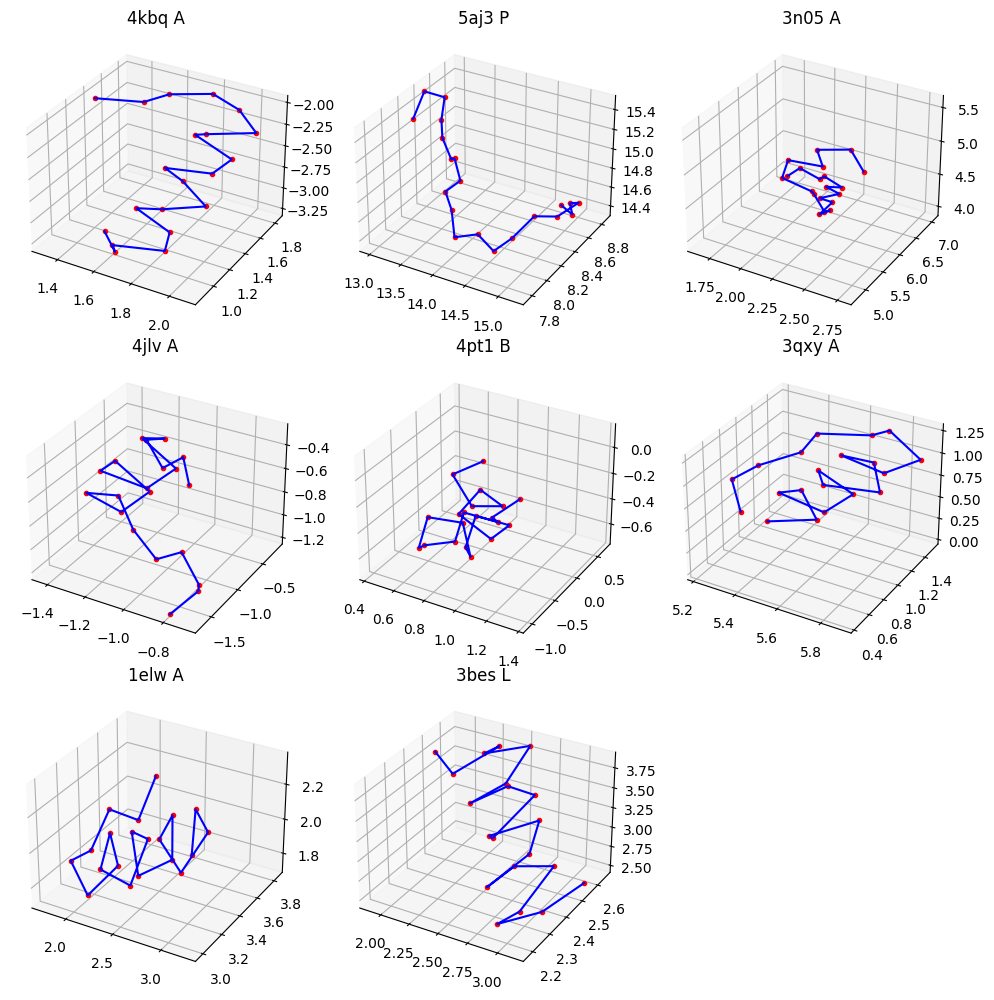

In [10]:
for batch_idx, (pdb_id, res, data) in enumerate(train_loader):
    ca_coords = data[:,:,1,:] #n, ca, c
    pdb_chain = [(x[:4], x[4]) for x in pdb_id]
    show_Calpha_plots(pdb_chain[:8], ca_coords[:8]) 
    break

## Visualization of forward diffusion process

PDB id:5ea0 H


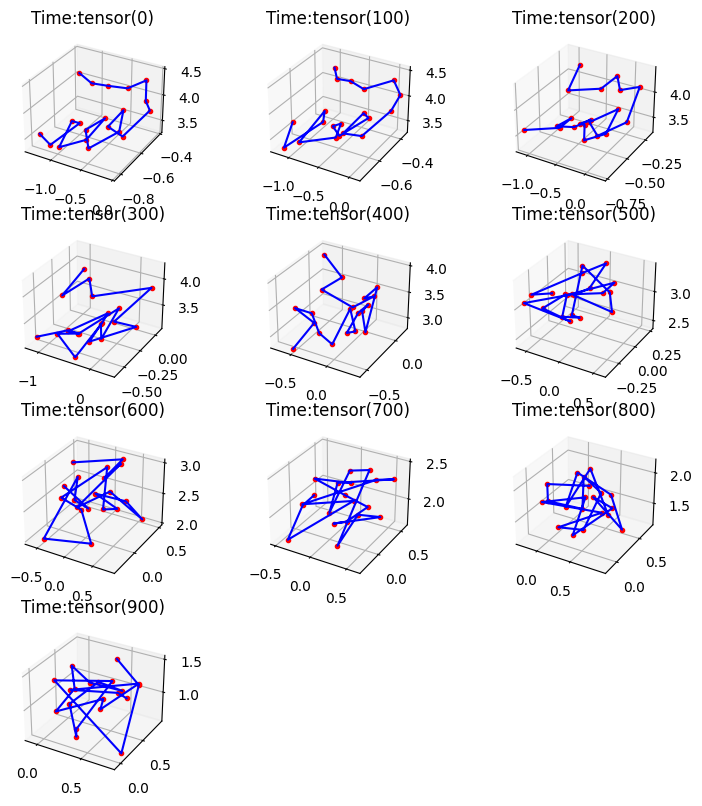

In [5]:
pdb_chain = next(iter(train_loader))[0][0]
ca_coords = next(iter(train_loader))[1][0]
ca_coords = ca_coords.reshape(1,20,3)
ddpm = Diffusion() # Defualt settings
show_foward_diffusion(ddpm, pdb_chain, ca_coords, 1000)

## Train model

In [6]:
def train(epoch: int, diffusion: nn.Module, eps_model: nn.Module, device, optimizer):
    eps_model.train()
    train_loss = 0.0
    for batch_idx, (_, data, _) in enumerate(tqdm(train_loader, leave=False)):
        data = data.to(device)
        data = data.unsqueeze(1) # dim: [128, 1, 20, 3]
        batch_size = data.shape[0]
        t = diffusion.sample_timesteps(batch_size = batch_size).to(device)
        x_t, eps = diffusion.q_sample(data, t)
        
        predicted_eps = eps_model(x = x_t.float(), t = t)
        optimizer.zero_grad()
        loss = F.smooth_l1_loss(predicted_eps, eps)
        train_loss += loss
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.10f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
diffusion = Diffusion(timesteps=1000, beta_schedule='cosine', device=device)
eps_model = UNet(in_channels=1, out_channels=1, noise_steps=1000, time_dim=128).to(device)
optimizer = optim.Adam(params=eps_model.parameters(), lr = 1e-3)
for epoch in range(1, 51):   
    train(epoch=epoch, diffusion=diffusion, eps_model=eps_model, device=device, optimizer=optimizer)



====> Epoch: 1 Average loss: 0.0025516157


====> Epoch: 2 Average loss: 0.0025507995


====> Epoch: 3 Average loss: 0.0025497553


====> Epoch: 4 Average loss: 0.0025522334


====> Epoch: 5 Average loss: 0.0025482459


====> Epoch: 6 Average loss: 0.0025494910


====> Epoch: 7 Average loss: 0.0025481751


====> Epoch: 8 Average loss: 0.0025530362


====> Epoch: 9 Average loss: 0.0025516033


====> Epoch: 10 Average loss: 0.0025498690


====> Epoch: 11 Average loss: 0.0025514269


====> Epoch: 12 Average loss: 0.0025471685


====> Epoch: 13 Average loss: 0.0025488325


====> Epoch: 14 Average loss: 0.0025504661


====> Epoch: 15 Average loss: 0.0025498160


====> Epoch: 16 Average loss: 0.0025494736


====> Epoch: 17 Average loss: 0.0025508751


====> Epoch: 18 Average loss: 0.0025514634


====> Epoch: 19 Average loss: 0.0025493507


====> Epoch: 20 Average loss: 0.0025533609


====> Epoch: 21 Average loss: 0.0025470355


====> Epoch: 22 Average loss: 0.0025472184


====> Epoch: 23 Average loss: 0.0025501392


====> Epoch: 24 Average loss: 0.0025499157


====> Epoch: 25 Average loss: 0.0025512126


====> Epoch: 26 Average loss: 0.0025485742


====> Epoch: 27 Average loss: 0.0025448636


====> Epoch: 28 Average loss: 0.0025480359


====> Epoch: 29 Average loss: 0.0025521174


====> Epoch: 30 Average loss: 0.0025510182


====> Epoch: 31 Average loss: 0.0025470778


====> Epoch: 32 Average loss: 0.0025511112


====> Epoch: 33 Average loss: 0.0025492427


====> Epoch: 34 Average loss: 0.0025486583


====> Epoch: 35 Average loss: 0.0025476082


====> Epoch: 36 Average loss: 0.0025498748


====> Epoch: 37 Average loss: 0.0025487760


====> Epoch: 38 Average loss: 0.0025497677


====> Epoch: 39 Average loss: 0.0025529341


====> Epoch: 40 Average loss: 0.0025521235


====> Epoch: 41 Average loss: 0.0025504768


====> Epoch: 42 Average loss: 0.0025535303


====> Epoch: 43 Average loss: 0.0025484765


====> Epoch: 44 Average loss: 0.0025512563


====> Epoch: 45 Average loss: 0.0025519507


====> Epoch: 46 Average loss: 0.0025486947


====> Epoch: 47 Average loss: 0.0025487620


====> Epoch: 48 Average loss: 0.0025501087


====> Epoch: 49 Average loss: 0.0025512673


====> Epoch: 50 Average loss: 0.0025494050
